## Tutorial 24: Deep Learning and JAX

## PHYS 5070, Spring 2021

In [1]:
## Common import cell!

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import jax
import jax.numpy as jnp

## T24.1 - JAX: NumPy + acceleration + autograd (+ more!)

Before we get to deep learning, let's meet [the JAX module](https://jax.readthedocs.io/en/latest/) in some detail.

### Part A

Let's start with automatic gradients.  Consider the following simple function for the squared length of a vector $\mathbf{x}$:
\\[
f(\mathbf{x}) = \sum_i x_i^2
\\]

We can compute the gradient of this function by hand, of course:
\\[
\nabla_x f(\mathbf{x}) = 2\mathbf{x}.
\\]


The `jax.grad()` function will transform a Python function into a new function equal to the gradient.  Here's an example, which we can easily compare to the by-hand gradient:

In [3]:
def sum_squares(x):
    return jnp.sum(x**2)

x_test = np.arange(1.,5.)
print(sum_squares(x_test))
print(jax.grad(sum_squares)(x_test))

30.0
[2. 4. 6. 8.]


Note that we must use the JAX version of the NumPy function `np.sum` - again, JAX is meant to be a "drop-in replacement", which means that generally we just replace `np` with `jnp` to do this.  A related function is `jax.value_and_grad()`, which returns both the value of the function as well as its gradient as a two-element tuple.  Try it out on `x_test` in the cell below.

In [20]:
jax.value_and_grad(sum_squares)(x_test)

(DeviceArray(30., dtype=float32), DeviceArray([2., 4., 6., 8.], dtype=float32))

### Part B

One of the components of JAX that works quite differently from the corresponding part of NumPy is __random number generation__.  Specifically, the way that control of the pseudo-RNG seed works is rather different.  In NumPy, if we set the seed with `np.random.seed()`, the output of any random code from that point forward is deterministic - but we don't spend any time thinking about the _state_ of the RNG, we just set the seed once.

In JAX, this approach will _not_ work in general.  The reason is that JAX is designed for efficient use of computing platforms like GPUs, which carry out parallel operations.  We haven't talked much about parallel execution of code yet, but it should be clear that if we try to run two pieces of code at the same time, the state of the RNG becomes ambiguous - it depends on which part happens first.

For this reason, any calls to the JAX random number generator require _explicit_ invocation of the PRNG key.  Compare the NumPy and JAX calls below to produce the same selections of random numbers:



In [21]:
s = np.random.seed(19)
r_np = np.random.rand(2)

key = jax.random.PRNGKey(19)
r_jax = jax.random.uniform(key, (2,))

print(s, r_np)
print(key, r_jax)

None [0.0975336  0.76124972]
[ 0 19] [0.97604656 0.5865028 ]


So far, the results are the same, except that the NumPy key exists in the background as a global state, whereas we have to carry the JAX key around as a variable.  The difference comes if we want to call the RNG a _second_ time.  If we call `jax.random.uniform(key, (2,))` again, since `key` hasn't been changed since we first assigned it, we'll get exactly the same output again - probably not what we intended!

We could just make a brand-new key with a new seed, but this is very inconvenient: now we have to change two seeds instead of just one if we want to get a different random result.  Seeding by hand would be especially bad if we want to run our RNG in any kind of loop.  To avoid this issue, JAX offers the `jax.random.split` method, which takes an existing key and generates new keys (two, by default) using the PRNG.  So the workflow for JAX random numbers is: every time we call the PRNG, we make sure to split the key first.

Finish the cell below: __create a new array `r_jax_3`__ using `jax.random.uniform` and `jax.random.split`, to make sure it's a _different_ random array from `r_jax` and `r_jax_2`.

In [22]:
r_np_2 = np.random.rand(2)
r_jax_2 = jax.random.uniform(key, (2,))

### BEGIN SOLUTION
key2, key3 = jax.random.split(key)
r_jax_3 = jax.random.uniform(key2, (2,))
### END SOLUTION

print(r_np, r_np_2)
print(r_jax, r_jax_2, r_jax_3)

[0.0975336  0.76124972] [0.24693797 0.13813169]
[0.97604656 0.5865028 ] [0.97604656 0.5865028 ] [0.40633547 0.12231553]


### Part C

Let's finish our JAX warmup with a slightly more complete example.  Before we get to a neural network, we'll run through a much simpler machine learning problem: model regression.  Linear regression is too easy, so we'll use the simple non-linear model
\\[
f(x) = \frac{a}{b + x^2}.
\\]

We'll adopt the "model truth" to be $a = 0.3, b = 0.5$, generate some data including Gaussian noise, and then try to fit the model and find the parameter values from the noisy data.  I've done the initial setup for you: __run the cell below__ to generate the noisy data and make a plot comparing it to the model truth curve.

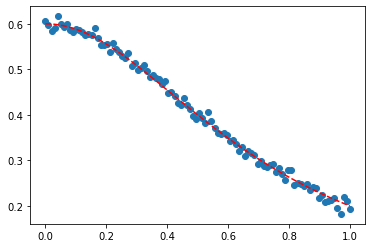

In [23]:
key = jax.random.PRNGKey(5070)

def model(p, x):
    return p[0] / (p[1] + x**2)

x = np.linspace(0,1,100)
y_truth = model([0.3, 0.5], x)
noise = 0.01*jax.random.normal(key, (100,))

y = y_truth + noise

plt.scatter(x,y)
plt.plot(x,y_truth, color='r', linestyle='--')

To carry out the regression, we need a cost function to minimize.  We'll use the standard least-squares method, so our cost function will be

\\[
C(p) = \sum_i (y_i - f(p,x_i))^2
\\]

which we'll minimize over the parameter vector $p = (a,b)$.  

This brings us to our next JAX topic, __JIT compilation__.  I've implemented two versions of the loss function in the cell below: one using ordinary NumPy, and one using the JAX version.  Note that the second version includes the funny-looking `@jax.jit` just above the function definition.  This is a special Python construction called a __decorator.__  It is shorthand notation for the equivalent statement

```python
def loss_jax():
    ...
    
loss_jax = jax.jit(loss_jax)
```

i.e. a decorator (always denoted with the `@` symbol) applies the given method to our function in order to modify its definition.  __Run the cell below__ to load these function definitions.

In [8]:
def loss_np(p, x, y):
    return np.mean( (y - model(p, x))**2 )
    
@jax.jit
def loss_jax(p, x, y):
    return jnp.mean( (y - model(p, x))**2 )

Now __run the next two cells__ to see a timing comparison for calling each version of the loss function.  You should see a significant speed-up even on this modest 100-point dataset - I get about a factor of 10 improvement for the JIT-compiled version of the code!

In [10]:
%timeit loss_np([1.,1.], x, y)

180 µs ± 4.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%timeit loss_jax([1.,1.], x, y)

21.1 µs ± 244 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Now we need an update algorithm to go with our loss function.  We'll use simple __gradient descent__: at each step, the parameters are updated according to the algorithm

\\[
p' = p - l \nabla_p C(p).
\\]

Here $l$ is a constant called the __learning rate__, typically less than 1 - you can experiment with the value but I used $0.1$ as my default.  (The learning rate is an example of a __hyperparameter__: although the final results of your machine learning should not depend on it at all, tuning its value may lead to quicker convergence of your program.)

__Implement the `update` function below__ to return the new value of `p` using gradient descent given the inputs.

In [15]:
@jax.jit
def update(p, x, y, learn_rate=0.1):
    ### BEGIN SOLUTION
    return p - learn_rate * jax.grad(loss_jax)(p,x,y)
    ### END SOLUTION

Now we're ready to learn!  In the interest of time, I'll give you the full implementation for this part, so you can just __run the next three cells__ and hopefully end up with estimates for $a$ and $b$ close to the model truth (0.3 and 0.5, respectively.)  The overall algorithm is something that will be repeated when we run the much more complicated deep neural network:

- Set up some initial parameters for your model.
- In a for loop, repeatedly update the parameters using an algorithm to attempt to minimize the cost function.
- Keep track of the loss and parameter estimates vs. update number, so you can monitor convergence.

In [17]:
p0 = jnp.array([1., 1.])

p_hist = [p0]
loss_hist = []

p = p0
for _ in range(5000):
    p = update(p, x, y)
    p_hist.append(p)
    loss_hist.append(loss_jax(p,x,y))
    
print("Final parameter estimate: ", p)
print("Final loss: ", loss_jax(p,x,y))

Final parameter estimate:  [0.29846323 0.49662212]
Final loss:  7.526761e-05


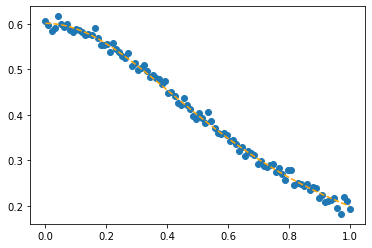

In [18]:
plt.scatter(x,y)
plt.plot(x,model(p,x), color='orange', linestyle='--')

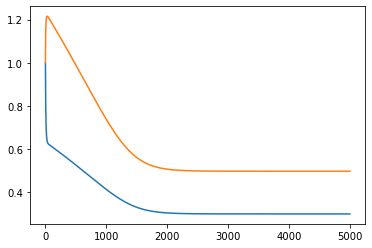

In [19]:
plt.plot(p_hist)

## T24.2 - Building our own deep neural network

Now let's move on to the fun part: building our own feed-forward deep neural network.  The network itself, as we discussed, can be represented as a set of weights and biases associated with each neuron and its connections.

Let $m$ be the width of the previous layer, and $n$ the width of the current layer.  The output of the `i`-th neuron in the given layer is a weighted sum of the outputs from the previous layer, plus a bias term, with our activation function $\sigma$ applied:

\\[
O'_i = \sigma(\sum_{j=1}^m w_{ij} O_j + b_i)
\\]

The parameters to be adjusted are the weights and the bias.  So for a given layer, we need to keep track of the 2-d tensor $w$ and the 1-d tensor (vector) $b$.

To represent our entire network, then, we just need a list of length $d$, where $d$ is the depth (i.e. number of layers), and each entry in the list is a 2-component list containing $(w,b)$.

We'll explicitly create a __binary classifier__, which means our final (output) layer always consists of a single neuron.  We'll use a logistic model for the associated probability, i.e.

\\[
p(y = 1) = \frac{1}{1+\exp(-w^T O)}
\\]
based on a final set of weights and the output of the previous layer (and with zero bias for the final layer.)

### Part A

Let's start with a function that will set up our neural network.  We'll use randomized Gaussian values for the initial weights and biases using `jax.random.normal()`.  __Finish the implementation__ of `init_binary_DNN` below.  In addition to the PRNG key, it takes a list `layer_widths` as input, which encodes the width and depth of all of the layers, input layer first.  (The output layer is implicit, i.e. `layer_widths = [3,3]` is a depth-3 neural network with one input layer of 3 neurons, one hidden layer of 3 neurons, and one output layer of 1 neuron.)

_Important note:_ the input layer does NOT have any weights - its values will be taken from data, without transformation.  So only the _second_ layer and beyond will have weights associated with them.  The implicit output layer _does_ have weights associated with it, don't forget them!

In [24]:
def init_binary_DNN(key, layer_widths):
    nn = []
    M = layer_widths[0]
    
    keys = jax.random.split(key, len(layer_widths))

    ### BEGIN SOLUTION
    for i in range(1,len(layer_widths)):
        N = layer_widths[i]
        M = layer_widths[i-1]

        w_key, b_key = jax.random.split(keys[i])

        w = jax.random.normal(w_key, (N,M))
        b = jax.random.normal(b_key, (N,))
        
        nn.append([w,b])
        
    # Prepare final layer
    w_key, b_key = jax.random.split(keys[-1])
    w_final = jax.random.normal(w_key, (1,N))
    b_final = jnp.array([0.])

    ### END SOLUTION
    
    nn.append([w_final,b_final])
        
    return nn
        

In [25]:
key = jax.random.PRNGKey(7)
test_nn = init_binary_DNN(key, [3,3])
print(test_nn)

# Check depth
assert len(test_nn) == 2

# Check sizes of layers
layer_1 = test_nn[0]
assert layer_1[0].shape == (3,3)
assert layer_1[1].shape == (3,)

layer_2 = test_nn[1]
assert layer_2[0].shape == (1,3)
assert layer_2[1].shape == (1,)

[[DeviceArray([[ 0.80897665,  1.4005336 ,  0.29912567],
             [ 0.44514143, -1.2071526 , -0.7609591 ],
             [-1.7980846 ,  0.6246169 , -0.29764697]], dtype=float32), DeviceArray([-0.61036974, -0.18488751, -1.3075838 ], dtype=float32)], [DeviceArray([[-1.1901789,  1.4655813, -0.4826649]], dtype=float32), DeviceArray([0.], dtype=float32)]]


### Part B

To actually make this a neural net, we need an activation function on top of our linear weights.  There are several common choices, as mentioned in lecture.  Although I haven't yet introduced the problem we want to solve yet, I'll select the `tanh` function layer as a simple choice and based on some experimentation that I did.  (ReLU and cousins may perform better, feel free to experiment!)

Recall that the outputs of a single layer of our net can be written in the form

\\[
O'_i = \sigma(\sum_{j=1}^m w_{ij} O_j + b_i)
\\]

To evaluate the first term, we need to sum over a matrix-vector product.  This is easiest to think about clearly by writing out the indices and the sum explicitly, as I have done above.  However, for efficiency we want to use vectorized functions and not `for` loops.  The good news is that JAX (and also NumPy itself!) support the use of __Einstein summation notation__ with the `einsum` method.  

Since this is a physics class I don't have to explain Einstein notation, we can just use it right away.  I do have to briefly explain how the notation works with NumPy, though.  Basically, we write the indices explicitly for each object in the sum, separated by commas.  Repeated indices are summed over, singular ones are not.  There are some fancier constructions that can be used to restrict the sums and e.g. extract the diagonal components of a matrix with this notation, have a look [at the documentation](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) to learn more.

In the cell below, use `jnp.tanh()` with `jnp.einsum()` to implement the function above for a single layer of our neural net (which, you'll recall from part A, is a 2-tuple of the form `(w,b)`.)

In [26]:
def tanh_layer(layer, o):
    ### BEGIN SOLUTION
    return jnp.tanh(jnp.einsum('ij,j', layer[0], o) + layer[1])
    ### END SOLUTION

In [27]:
Ltest = tanh_layer(test_nn[0], [1,-2,1])
assert Ltest.shape == (3,)

Now we need to compose the layer transformation to act on our entire neural net, propagating from inputs to outputs.  For the output, we have a final step: the output of the final neuron is

\\[
p(y = 1) = \frac{1}{1+\exp(-w^T O)}
\\]

using the outputs `O` from the next-to-last layer.  Then we can take this output probability and implement the logistic cross-entropy as our loss function (this is just the negative log-likelihood for the logistic probability function, see tutorial 23.)

__Implement the `propagate` function__ below, to give the output of a neural net given the net's weights and a set of inputs (a vector the same length as the neural net's first layer.)  I've given you the loss function based on `propagate` immediately afterwards.  Note that this uses the `jnp.clip()` method to keep the values of the `pred_y` variable away from exactly 0 or exactly 1, where they will cause our logarithms to blow up.

In [30]:
def propagate(nn, inputs):
    # Loop over all hidden layers
    
    ### BEGIN SOLUTION
    
    o = inputs
    for layer in nn[:-1]:
        o = tanh_layer(layer, o)
        
    # Final outputs as probability using logistic function
    w, b = nn[-1]
    return (1 /(1 + jnp.exp(-jnp.einsum('ij,j', w, o))))[0]

    ### END SOLUTION

def loss_CE(nn, inputs, y):
    eps = 1e-6
    pred_y = propagate(nn, inputs)
    pred_y = jnp.clip(pred_y, eps, 1 - eps)
    return -y * jnp.log(pred_y + 1e-8) - (1-y) * jnp.log(1-pred_y + 1e-8)

In [31]:
print(propagate(test_nn, [1.,1.,1.]))
print(loss_CE(test_nn, [1.,1.,1.], 1))

0.11595461
2.1545563


### Part C

So far all of our code has been very generic.  Now we set up the details based on a specific problem, which will be phases of the 2-d Ising model.  __Run the cell below__ to import the dataset and set up some testing and training datasets.  (This dataset and some code below are taken from [http://physics.bu.edu/~pankajm/MLnotebooks.html](http://physics.bu.edu/~pankajm/MLnotebooks.html), associated with the assigned reading.)

The data consist of spin configurations (up or down at each site) for a two-dimensional 40x40 grid, generated using Markov chain Monte Carlo methods.  The configurations are generated for a range of temperatures, on either side of a finite-temperature phase transition between a low-T ordered phase and a high-T disordered one.  Furthermore, a set of _labels_ are provided

In [33]:
import pickle
data = pickle.load(open('./IsingData/Ising2DFM_reSample_L40_T=All.pkl', 'rb')) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data = data.astype('float')
data[np.where(data==0)]=-1 # map 0 state to -1


labels = pickle.load(open('./IsingData/Ising2DFM_reSample_L40_T=All_labels.pkl', 'rb'))
labels = labels.astype('float')

print(data.shape)
print(labels.shape)

def vis_ising(spin_config):
    s = spin_config.reshape(40,40)
    return plt.imshow(s)

(160000, 1600)
(160000,)


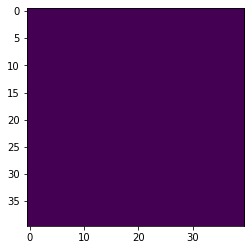

In [34]:
vis_ising(data[2500])  # Ordered low-temperature phase - should be very uniform

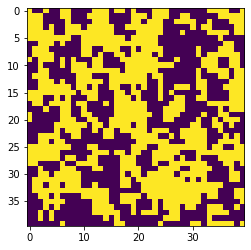

In [35]:
vis_ising(data[130000])  # Disordered high-temperature phase - should be fairly random-looking

In [36]:
from sklearn.model_selection import train_test_split

def prepare_data(data, labels, test_size=0.2):
    
    L=40 # linear system size

    # divide data into ordered, critical and disordered
    X_ordered=data[:70000,:]
    Y_ordered=labels[:70000]

    X_critical=data[70000:100000,:]
    Y_critical=labels[70000:100000]

    X_disordered=data[100000:,:]
    Y_disordered=labels[100000:]

    # define training and test data sets
    X=np.concatenate((X_ordered,X_disordered)) 
    Y=np.concatenate((Y_ordered,Y_disordered))

    # pick random data points from ordered and disordered states to create the training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, train_size=1.0-test_size)

    # create data sets
    dataset = {
        'train': (X_train, Y_train),
        'test': (X_test, Y_test),
        'critical': (X_critical, Y_critical),
    }

    return dataset

In [37]:
ising_data = prepare_data(data, labels)

Now we'll use our prepared code above to create an Ising neural network.  I've chosen an initial network with a single hidden layer of 100 neurons: __feel free to adjust__, this is not an exact science!

In [38]:
key = jax.random.PRNGKey(7)
ising_nn = init_binary_DNN(key, [1600, 100])

Now, we wrote the functions above to apply to a single set of inputs at a time.  However, it will be very useful to do __batch processing__ for training our neural net; running many inputs through at once and computing an overall cost.  To do this without explicit rewriting of our code, we can use one more JAX transformation called `jax.vmap` to __vectorize__ the existing `propagate` function.  We don't have time to get into details on this, so I've simply implemented the batch version of the loss function for you in the cell below.

In [39]:
batch_prop = jax.vmap(propagate, in_axes=(None,0), out_axes=0)

@jax.jit
def batch_loss(nn, inputs, y):
    eps = 1e-6
    pred_y = batch_prop(nn, inputs)
    pred_y = jnp.clip(pred_y, eps, 1 - eps)
    return np.sum(-y * jnp.log(pred_y) - (1-y) * jnp.log(1-pred_y))


Next, we need an optimizer.  Instead of doing simple gradient descent by hand (which won't be sufficient this time), we'll use one of the optimizers provided by JAX.  Then we apply an update to our neural net at each step of the optimizer based on the loss function (and its gradient.)

There is a bunch of boilerplate code for this, so simply __run the cell below__ to set up the `update` function.  Feel free to adjust the optimizer parameters and even the choice of optimizers; by default the code below uses the ADAM adaptive algorithm, but you can trying the stochastic gradient descent with `optimizers.sgd` by uncommenting that line (and commenting out the ADAM line.)

In [41]:
from jax.example_libraries import optimizers

lr = 1e-6
step_size = 1e-3
#opt_init, opt_update, get_params = optimizers.sgd(lr)
opt_init, opt_update, get_params = optimizers.adam(step_size)

opt_state = opt_init(ising_nn)

@jax.jit
def update(nn, inputs, y, opt_state):
    L, g = jax.value_and_grad(batch_loss)(nn, inputs, y)
    opt_state = opt_update(0, g, opt_state)
    return get_params(opt_state), opt_state, L


Now, we get to train our neural net!  Here are the steps:
- Divide the training data into __batches__.  There are 104,000 samples in the training set; I used 104 samples of size 1000 as my first attempt.
- Run a `for` loop over the batches, calling the `update` function to update your neural net at each step.
- It's generally useful to run many times over the same training data, since this is a stochastic process.  So choose a number of __training epochs__, and run an outer loop which simply repeats the batch training process for each epoch.

It's useful to keep track of the loss at the end of each epoch, to verify that your neural net is converging (the loss is decreasing.)  Looking at the individual weights won't be helpful because there are so many of them, but another good thing to keep track of is the __performance__ on both the testing and training sets; how many of the labels does your neural net get correct as it progresses?

From here on out, things are up to you!  Adjust the hyperparameters, monitor things, and see how well you can do - my attempt gave about a 95% accuracy rate on the training dataset, 85% on testing and 55% on the most difficult "critical" set.

In [313]:
loss_series = []
for epoch_i in range(50):
    for batch_i in range(104):
        ising_nn, opt_state, loss = update(ising_nn, 
                                     ising_data['train'][0][1000*batch_i:1000*(batch_i+1)], 
                                     ising_data['train'][1][1000*batch_i:1000*(batch_i+1)], 
                                     opt_state)
        loss_series.append(loss)
    print(f"Epoch {epoch_i}: final loss {loss}")

Epoch 0: final loss 403.353515625
Epoch 1: final loss 395.34033203125
Epoch 2: final loss 388.0944519042969
Epoch 3: final loss 379.5979309082031
Epoch 4: final loss 371.0047607421875
Epoch 5: final loss 362.9255676269531
Epoch 6: final loss 355.5177001953125
Epoch 7: final loss 348.7552490234375
Epoch 8: final loss 343.0290832519531
Epoch 9: final loss 335.9337158203125
Epoch 10: final loss 329.92144775390625
Epoch 11: final loss 324.61614990234375
Epoch 12: final loss 320.0223083496094
Epoch 13: final loss 314.8876953125
Epoch 14: final loss 310.20703125
Epoch 15: final loss 303.73822021484375
Epoch 16: final loss 297.6961364746094
Epoch 17: final loss 292.4075622558594
Epoch 18: final loss 287.65716552734375
Epoch 19: final loss 282.5646057128906
Epoch 20: final loss 277.92901611328125
Epoch 21: final loss 273.3440246582031
Epoch 22: final loss 269.1236877441406
Epoch 23: final loss 265.9330139160156
Epoch 24: final loss 262.5700378417969
Epoch 25: final loss 258.5312805175781
Epoch

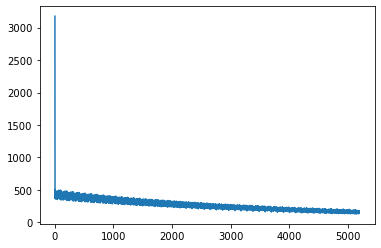

In [317]:
plt.plot(loss_series)

In [314]:
predict_train_class = (batch_prop(ising_nn, ising_data['train'][0][0:]) > 0.5)
predict_train_class.shape

(104000,)

In [315]:
np.sum(ising_data['train'][1].astype(bool) == predict_train_class) / len(predict_train_class)

DeviceArray(0.9445865, dtype=float32)

In [316]:
predict_test_class = (batch_prop(ising_nn, ising_data['test'][0][0:]) > 0.5)
np.sum(ising_data['test'][1].astype(bool) == predict_test_class) / len(predict_test_class)

DeviceArray(0.8431923, dtype=float32)

In [319]:
# Critical data set, which is the real challenge
predict_test_class = (batch_prop(ising_nn, ising_data['critical'][0][0:]) > 0.5)
np.sum(ising_data['critical'][1].astype(bool) == predict_test_class) / len(predict_test_class)

DeviceArray(0.55806667, dtype=float32)